## Import Packages

In [58]:
import copy
import os
import numpy as np
import pandas as pd
import zipfile
from simple_downloader import download
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader

# Training on UCMerced Dataset
## Download UCMerced Dataset from TUB-Cloud

Following workflow from Lab01, creating directory "./data", downloading UCMerced dataset zip-file and unzipping it.

In [59]:
download_dir = Path("./data")
download_dir.mkdir(exist_ok=True)
TUB_URL = "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip"
output_file = download(TUB_URL, "./data/")
#Is Already extracted no need to do again
#zipf = zipfile.ZipFile(output_file)
#zipf.extractall(path="data")

Target file already exists!
Will skip download. To force download set `force=True`


In [60]:
mylabels = np.array(["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks", "trees","water"])

# Statistical Analysis

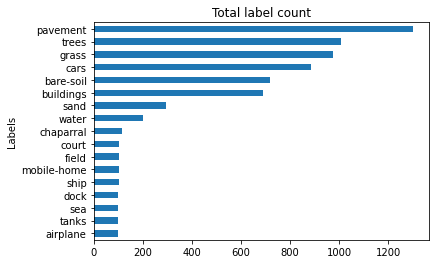

In [219]:
df = pd.read_csv(os.path.join("./data/UCMerced_LandUse","multilabels","LandUse_Multilabeled.txt"),sep="\t",index_col=0)
ax = df.sum().sort_values(ascending=True).plot(kind="barh",ylabel="Labels",title="Total label count")
fig = ax.get_figure()
fig.savefig(transparent=True,fname="./images/label_composition.eps",format="eps")

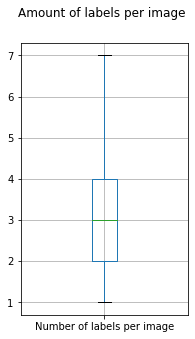

In [220]:
nl = pd.DataFrame({"Number of labels per image":df[[col for col in df.columns if col not in ["Number_of_labels_per_image"]]].sum(axis=1)})
ax = nl.boxplot()#"Number_of_labels_per_image")
fig = ax.get_figure()
fig.set_size_inches(3,5)
fig.suptitle('Amount of labels per image')
fig.savefig(transparent=True,fname="./images/label_boxplot.eps",format="eps")

<AxesSubplot:>

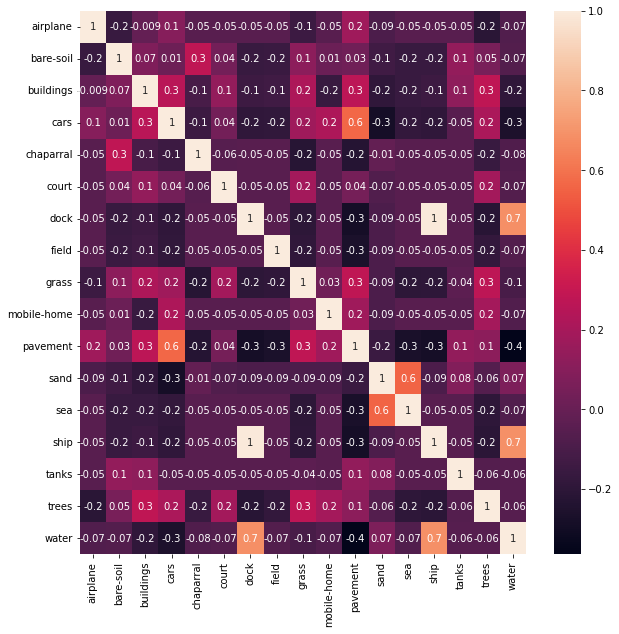

In [223]:
#Pearson orrelation coefficient matrix
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(method="pearson"),annot=True,fmt=".0g",)

## Define Customized Dataset in PyTorch

In [61]:
class UCMerced(Dataset):
    def __init__(self, root_dir, img_transform=None, multilabel=False):

        self.root_dir = root_dir
        self.images_path = os.path.join(root_dir, "Images")
        self.class_names = sorted(
            [cl for cl in os.listdir(self.images_path) if not cl.startswith(".")]
        )
        self.img_paths, self.img_labels = self.init_dataset()
        self.img_transform = img_transform

        if multilabel:
            self.img_labels = self.read_multilabels()  # important for loss calculation
            self.img_labels = self.img_labels.astype(float)

    def init_dataset(self):
        img_paths, img_labels = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = os.path.join(self.images_path, cl_name)

            for img in sorted(os.listdir(cl_path)):
                img_path = os.path.join(cl_path, img)
                img_paths.append(img_path)
                img_labels.append(cl_id)

        return img_paths, img_labels

    def read_multilabels(self):
        return pd.read_csv(os.path.join(self.root_dir,"multilabels","LandUse_Multilabeled.txt"),sep="\t",index_col=0).to_numpy() 
        

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return dict(img=img, label=label)

    def __len__(self):
        return len(self.img_paths)

## Helper Functions

In [62]:
class MetricTracker(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [63]:
def get_device(cuda_int):
    """Get Cuda-Device. If cuda_int < 0 compute on CPU."""
    if cuda_int < 0:
        print("Computation on CPU")
        device = torch.device("cpu")
    elif torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(cuda_int))
        device = torch.device("cuda:{}".format(cuda_int))
    return device

In [64]:
def get_dataset(root_dir, tr_transform, te_transform, set_sizes, seed=1, multilabel=False):
    """
    Parameter
    ---------
    root_dir     : path to UCMerced Dataset
    tr_transform : transformation for training data
    te_transform : transformation for training data
    set_sizes    : list of percentage of either train-test or train-val-test (sum to 100)

    Output
    ------
    sets for train and test, optionally also val if len(set_sizes)==3
    """
    ucm_dataset_tr = UCMerced(root_dir, img_transform=tr_transform, multilabel=multilabel)
    ucm_dataset_te = UCMerced(root_dir, img_transform=te_transform, multilabel=multilabel)
    idx_list = split_ucm_indices(set_sizes, seed=seed)

    train_set = Subset(ucm_dataset_tr, idx_list[0])
    test_set = Subset(ucm_dataset_te, idx_list[-1])

    if len(idx_list) > 2:
        val_set = Subset(ucm_dataset_te, idx_list[1])
        return train_set, val_set, test_set
    else:
        return train_set, test_set

In [65]:
def split_ucm_indices(set_sizes, num_samples=2091, num_classes=17, seed=1):
    """Compute indices for a class-balanced train-(val)-test split for UCMerced."""
    cl_samples = int(num_samples / num_classes)
    assert sum(set_sizes) == 100
    split_indices = list(map(int, np.cumsum(set_sizes)[:-1] / 100 * cl_samples))
    # class_idx_mat d x N (row: classes, columns: idx of sample in dataset)
    dataset_idx = np.arange(0, num_samples)
    class_idx_mat = np.reshape(dataset_idx, (num_classes, cl_samples))
    # random shuffle class_wise idx (=> per row)
    np.random.seed(seed)
    np.apply_along_axis(np.random.shuffle, 1, class_idx_mat)
    # return indices for splits (2 or 3)
    idx_list = np.hsplit(class_idx_mat, split_indices)
    # flatten set idx
    return list(map(lambda x: x.flatten(), idx_list))

In [66]:
def pretty_classification_report_print(report, class_names):
    N = len(class_names)
    df = pd.DataFrame(report).round(decimals=2)
    df = df.rename(columns=dict(zip(list(map(str, range(N))), class_names))).T
    df[["support"]] = df[["support"]].astype(int)
    return df

In [217]:
import seaborn as sns
def prettify_confusion_matrix(conf_mat, class_names,percent=False):
    col, row = 4,5
    fig, ax = plt.subplots(row, col, figsize=(10, 10))
    fig.set_tight_layout(True)
    ax[4,1].axis("off")
    ax[4,2].axis("off")
    ax[4,3].axis("off")
    mat = 0
    for i in range(row):
        for j in range(col):
            if mat < len(conf_mat):
                current_conf = conf_mat[mat]
                if percent:
                    current_conf = np.ndarray([2,2])
                    current_conf[0,0] = round((conf_mat[mat,0,0]) / (conf_mat[mat,0,0] + conf_mat[mat,0,1]),2)
                    current_conf[1,1] = round(conf_mat[mat,1,1] / (conf_mat[mat,1,1] + conf_mat[mat,1,0]),2)
                    current_conf[0,1] = round(conf_mat[mat,0,1] / (conf_mat[mat,0,1] + conf_mat[mat,0,0]),2)
                    current_conf[1,0] = round(conf_mat[mat,1,0] / (conf_mat[mat,1,1] + conf_mat[mat,1,0]),2)
                    current_conf = np.nan_to_num(current_conf)
                sns.heatmap(
                    current_conf,
                    cmap="PiYG", 
                    fmt="g",
                    #xticklabels=class_names,
                    #yticklabels=class_names,
                    annot=True,
                    ax=ax[i][j]
                )
                ax[i,j].set_title(class_names[mat])
                ax[i,j].set_ylabel("True")
                ax[i,j].set_xlabel("Predicted")
                mat+=1

## Training and Evaluation Functions

In [68]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, early_stop=False):
    train_losses, val_losses = [], []
    accuracy_scores = []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in range(1, epochs + 1):

        print("Epoch {}/{}".format(epoch, epochs))
        print("-" * 10)

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, report, _ = val_epoch(model, val_loader, criterion, device)
        overall_acc = report["samples avg"]["f1-score"]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_scores.append(overall_acc)

        if best_acc < overall_acc:
            best_acc = overall_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch > 10 and early_stop:
            break

    return best_model, train_losses, val_losses, accuracy_scores

In [69]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    loss_tracker = MetricTracker()
    model.train()

    tqdm_bar = tqdm(train_loader, desc="Training: ")
    for batch in tqdm_bar:

        images = batch["img"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        optimizer.zero_grad()
        logits = model(images)
        #probs = torch.sigmoid(logits)# do i need sigmoid here?
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        loss_tracker.update(loss.item(), batch_size)
        tqdm_bar.set_postfix(loss=loss_tracker.avg)

    return loss_tracker.avg

In [70]:
def val_epoch(model, val_loader, criterion, device):
    loss_tracker = MetricTracker()
    model.eval()

    y_pred = np.zeros([0,17])
    y_true = np.zeros([0,17])

    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc="Validation: ")
        for batch in tqdm_bar:

            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            batch_size = images.size(0)
            logits = model(images)
            probs = torch.sigmoid(logits)
            loss = criterion(probs, labels)
            loss_tracker.update(loss.item(), batch_size)
            probs = np.where(np.array(probs)>=0.5, 1., 0.)#.tolist()
            #labels = labels.tolist()
            
            y_pred = np.concatenate((y_pred,probs),axis=0)#np.array([y_pred,probs],dtype=object)
            y_true = np.concatenate((y_true,labels),axis=0)#np.array([y_true,labels],dtype=object)
            #batch_acc = (probs == labels).sum().item() / batch_size
            #acc_tracker.update(batch_acc, batch_size)
            #tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)
    #print(y_pred,y_true)
    #print(y_pred.shape,y_true.shape)
    #print(y_pred.size,y_true.size)
    mAP_micro = average_precision_score(y_true,y_pred,average="micro")
    mAP_macro = average_precision_score(y_true,y_pred,average="macro")
    report = classification_report(y_true, y_pred, output_dict=True,zero_division=0,target_names=mylabels)
    report["mAP_micro"] = mAP_micro
    report["mAP_macro"] = mAP_macro
    conf_mat = multilabel_confusion_matrix(y_true, y_pred)

    return loss_tracker.avg, report, conf_mat

## Main Hyperparamter

In [71]:
batch_size = 64
learning_rate = 0.001
epochs = 3 # Number of individual validation runs
num_cls = 17
momentum = 0.9
weight_decay = 0.0001
nesterov = True
cuda_device = get_device(-1)


Computation on CPU


## Train- and Testset Transformation (i.e., Data Augmentation)

In [72]:
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]
baseline = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
affcont = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomAffine(degrees=10),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
jannis = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomRotation(15),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.RandomErasing(), ## Needs to be here to avoid shape errors with the erasing
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
randaug = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        #transforms.Lambda(lambda x : torch.from_numpy(np.array(x).astype(np.uint8).transpose(2,0,1))), # This works quite well to convert to unit8. however, there is a convinience function
        #transforms.ConvertImageDtype(dtype=torch.uint8),
        transforms.RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
        
        #transforms.ConvertImageDtype(torch.float32)
        
    ]
)

## Initializing Train-, Val-, Testset and Dataloader

In [73]:
split = [70,10,20] #3 Training Design

#Baseline
base_trainset, base_valset, base_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=baseline,
    te_transform=baseline,
    set_sizes=split,
    multilabel=True
)
base_train_loader = DataLoader(base_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
base_val_loader = DataLoader(base_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
base_test_loader = DataLoader(base_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

#Affine transformation & random auto contrast
affcont_trainset, affcont_valset, affcont_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=affcont,
    te_transform=affcont,
    set_sizes=split,
    multilabel=True
)
affcont_train_loader = DataLoader(affcont_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
affcont_val_loader = DataLoader(affcont_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
affcont_test_loader = DataLoader(affcont_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

#My own transformations
jannis_trainset, jannis_valset, jannis_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=jannis,
    te_transform=jannis,
    set_sizes=split,
    multilabel=True
)
jannis_train_loader = DataLoader(jannis_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
jannis_val_loader = DataLoader(jannis_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
jannis_test_loader = DataLoader(jannis_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

#Random augmentation
randaug_trainset, randaug_valset, randaug_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=randaug,
    te_transform=randaug,
    set_sizes=split,
    multilabel=True
)
randaug_train_loader = DataLoader(randaug_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
randaug_val_loader = DataLoader(randaug_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
randaug_test_loader = DataLoader(randaug_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Training the model

When using models that are pretrained on a different, usually bigger dataset (e.g. on the popular Computer Vision dataset ImageNet [1]) for a so-called downstream task in which the pretrained model is fine-tuned on the target dataset, we speak about Transfer Learning.

In this practice, try to use a pretrained version of the predefined `resnet18` model from Pytorch `models` library. You can achieve this by providing pretrained model weights to the weights parameter at initialization of the model. Use the following weights from the `torchvision` library: `torchvision.models.ResNet18_Weights.DEFAULT`. Finetune it on the train set of UCMerced dataset and evaluate the new model.

**Hint**: ImageNet consists of 1000 classes, therefore the last layer of the pretrained model needs to be alternated.

for more information check the pytorch documentation:

https://pytorch.org/docs/stable/torchvision/models.html

[1] https://www.image-net.org/index.php

In [75]:
from torchvision.models import ResNet18_Weights
from torchvision import models

## Baseline

In [107]:
#Take in the transfer Learning model
resnet_pretrained = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained.fc = nn.Linear(512, num_cls)#ResNet18 has a final layer that outputs 512 Nodes. We however want 17 so we chnage the final layer to have only 17 nodes though.
resnet_pretrained.to(cuda_device)
#Initialize the Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = optim.SGD(
    resnet_pretrained.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=nesterov,
)
#Execute the training of the model
base_best_model, base_train_losses, base_val_losses, base_accuracy_scores = train(
    resnet_pretrained,
    base_train_loader,
    base_val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    device=cuda_device,
)

Epoch 1/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

## Affine Transformation & Random auto contrast

In [77]:
#Take in the transfer Learning model
resnet_pretrained = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained.fc = nn.Linear(512, num_cls)#ResNet18 has a final layer that outputs 512 Nodes. We however want 17 so we chnage the final layer to have only 17 nodes though.
resnet_pretrained.to(cuda_device)

#Initialize the Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = optim.SGD(
    resnet_pretrained.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=nesterov,
)
#Execute the training of the model
affcont_model, affcont_train_losses, affcont_val_losses, affcont_accuracy_scores = train(
    resnet_pretrained,
    affcont_train_loader,
    affcont_val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    device=cuda_device,
)


Epoch 1/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

## Jannis Data augmentation

In [78]:
#Take in the transfer Learning model
resnet_pretrained = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained.fc = nn.Linear(512, num_cls)#ResNet18 has a final layer that outputs 512 Nodes. We however want 17 so we chnage the final layer to have only 17 nodes though.
resnet_pretrained.to(cuda_device)

#Initialize the Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = optim.SGD(
    resnet_pretrained.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=nesterov,
)
#Execute the training of the model
jannis_model, jannis_train_losses, jannis_val_losses, jannis_accuracy_scores = train(
    resnet_pretrained,
    jannis_train_loader,
    jannis_val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    device=cuda_device,
)

Epoch 1/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

## RandAugment augmentation

In [79]:
#Take in the transfer Learning model
resnet_pretrained = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained.fc = nn.Linear(512, num_cls)#ResNet18 has a final layer that outputs 512 Nodes. We however want 17 so we chnage the final layer to have only 17 nodes though.
resnet_pretrained.to(cuda_device)

#Initialize the Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = optim.SGD(
    resnet_pretrained.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=nesterov,
)
#Execute the training of the model
rand_best_model, rand_train_losses, rand_val_losses, rand_accuracy_scores = train(
    resnet_pretrained,
    randaug_train_loader,
    randaug_val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    device=cuda_device,
)

Epoch 1/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

## Collecting the metric data

In [108]:
#Put all the outputted metrics into easy to work with dictionaries
eval_accuracies = {}
eval_accuracies["baseline"] = base_accuracy_scores
eval_accuracies["affcont"] = affcont_accuracy_scores
eval_accuracies["jannis"] = jannis_accuracy_scores
eval_accuracies["randomaugment"]  = rand_accuracy_scores
eval_df = pd.DataFrame(eval_accuracies)
#Train Loss
train_losses = {}
train_losses["baseline"] = base_train_losses
train_losses["affcont"] = affcont_train_losses
train_losses["jannis"] = jannis_train_losses
train_losses["randomaugment"] = rand_train_losses
train_df = pd.DataFrame(train_losses)
#Val Loss
val_losses = {}
val_losses["baseline"] = base_val_losses
val_losses["affcont"] = affcont_val_losses
val_losses["jannis"] = jannis_val_losses
val_losses["randomaugment"] = rand_val_losses
val_df = pd.DataFrame(val_losses)

## Visualizing the metric data

Text(0, 0.5, 'Val Losses')

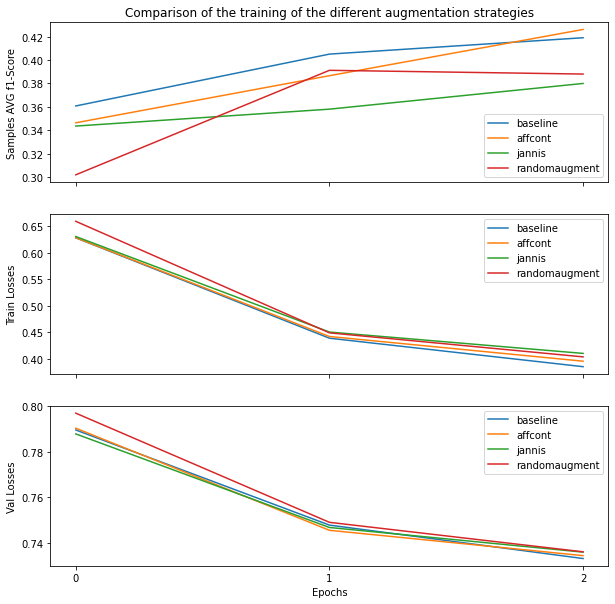

In [132]:
from matplotlib.ticker import MaxNLocator
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,10),sharex=True)
ax1.set_title("Comparison of the training of the different augmentation strategies")
ax1.plot(eval_df)
ax3.set_xlabel("Epochs")
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(eval_df.columns)
ax1.set_ylabel("Samples AVG f1-Score")
ax2.plot(train_df)
ax2.legend(train_df.columns)
ax2.set_ylabel("Train Losses")
ax3.plot(val_df)
ax3.legend(val_df.columns)
ax3.set_ylabel("Val Losses")
#ax3.set_yscale("log")

## Display example images for the different augmentation strategies

In [81]:
def label_individual_image(model,img):
    model.eval()
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
        probs = torch.sigmoid(logits)
        probs = np.where(np.array(probs)>=0.5, 1., 0.)[0]
    return probs   

def get_labels(labels,mylabels=mylabels)->list:
    return_labels = []
    labels = labels.tolist()
    for l in range(len(labels)):
        if labels[l] == 1.:
            return_labels.append(mylabels[l])
    return return_labels

def display_specific_image(model,loader,batch_nr,image_nr,method="Undefined",ax=None):
    number_of_batches = len(loader)
    current_batch = 0
    for b in loader:
        if current_batch != batch_nr:
            current_batch +=1 
            continue
        img = b["img"][image_nr]
        lab = b["label"][image_nr]
        probs = label_individual_image(model,img)
        aps = average_precision_score(lab,probs)
        img = img.numpy().transpose((1, 2, 0))
        img = ucm_std * img + ucm_mean
        img = np.clip(img,0.0,1.0)
        
        true_labels = get_labels(lab)
        pred_labels = get_labels(probs)
        if ax == None: fig, ax = plt.subplots()
        ax.set_xlabel(f"True {true_labels}")
        ax.set_title(f"Predicted {pred_labels}")
        ax.set_ylabel(f"Method {method}")
        ax.text(64,5,f"Precision:\n{aps}")
        current_batch +=1

        ax.imshow(img,norm=None)
        if current_batch >= number_of_batches: 
            break
    return ax

In [82]:
def get_good_images():
    current_batch = 0
    list_of_good_images = []
    for v in base_test_loader:
        for x in range(len(v["label"])):
            img = v["img"][x]
            lab = v["label"][x]
            probs = label_individual_image(base_best_model,img)
            aps =average_precision_score(lab,probs)
            if aps >= 0.8: 
                print(current_batch,x,aps,get_labels(lab),get_labels(probs))
                list_of_good_images.append((current_batch,x))
        current_batch += 1
    return list_of_good_images
#good_images = get_good_images() # Skip as i have already selected my favorits

1 16 0.8088235294117647 ['buildings', 'cars', 'pavement', 'trees'] ['buildings', 'cars', 'trees']
1 24 0.8088235294117647 ['buildings', 'grass', 'pavement', 'trees'] ['grass', 'pavement', 'trees']
1 26 0.8088235294117647 ['buildings', 'cars', 'pavement', 'trees'] ['buildings', 'pavement', 'trees']
2 2 0.8333333333333334 ['bare-soil', 'buildings', 'cars', 'pavement', 'trees'] ['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
2 13 0.8588235294117648 ['buildings', 'cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement', 'trees']
2 25 1.0 ['cars', 'pavement', 'trees'] ['cars', 'pavement', 'trees']
2 26 1.0 ['bare-soil', 'cars', 'pavement'] ['bare-soil', 'cars', 'pavement']
2 27 0.8088235294117647 ['cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement']
2 42 1.0 ['bare-soil', 'cars', 'pavement'] ['bare-soil', 'cars', 'pavement']
2 45 1.0 ['trees'] ['trees']
2 51 0.8088235294117647 ['cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement']
3 0 

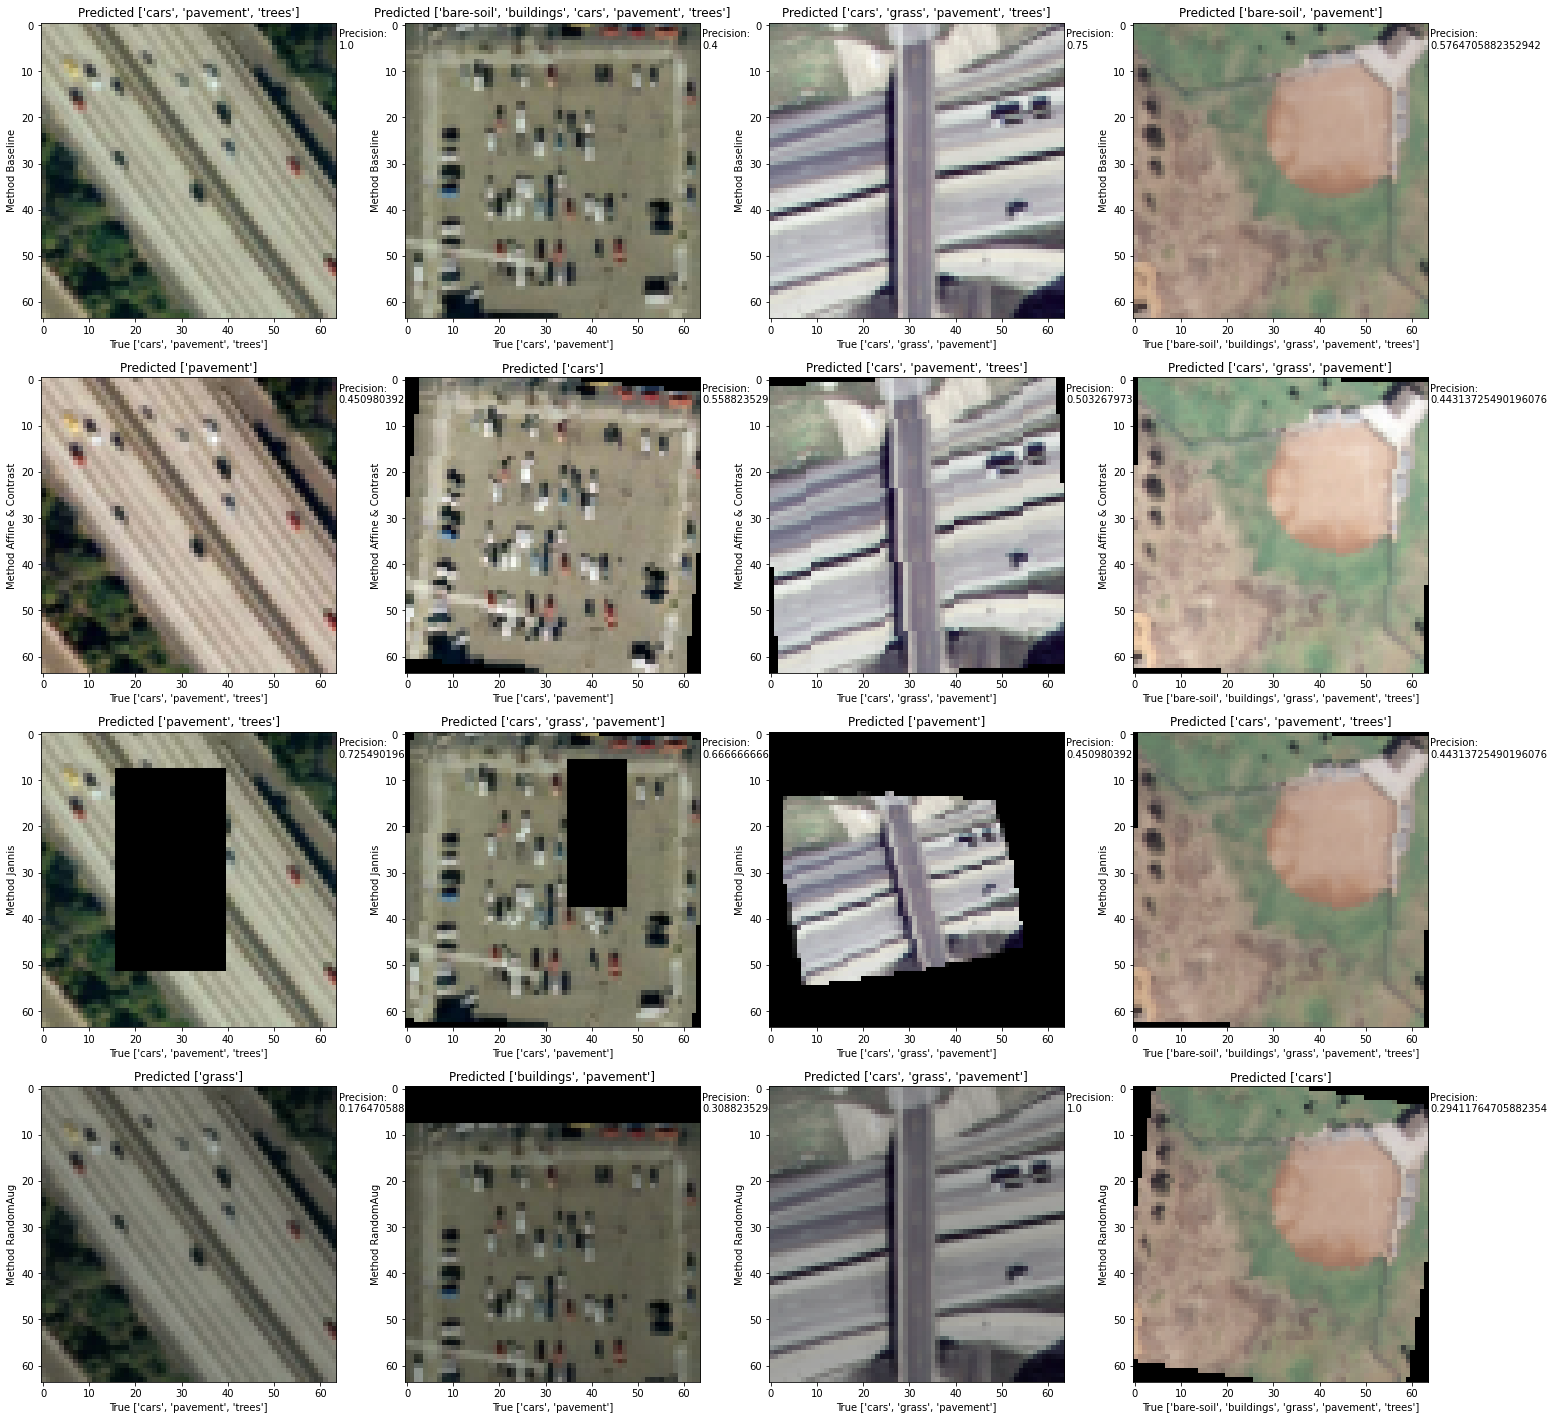

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,4,figsize=(25,25))

display_specific_image(base_best_model,base_test_loader,2,25,"Baseline",ax[0,0])
display_specific_image(base_best_model,base_test_loader,4,56,"Baseline",ax[0,1])
display_specific_image(base_best_model,base_test_loader,5,0,"Baseline",ax[0,2])
display_specific_image(base_best_model,base_test_loader,0,34,"Baseline",ax[0,3])

display_specific_image(affcont_model,affcont_test_loader,2,25,"Affine & Contrast",ax[1,0])
display_specific_image(affcont_model,affcont_test_loader,4,56,"Affine & Contrast",ax[1,1])
display_specific_image(affcont_model,affcont_test_loader,5,0,"Affine & Contrast",ax[1,2])
display_specific_image(affcont_model,affcont_test_loader,0,34,"Affine & Contrast",ax[1,3])

display_specific_image(jannis_model,jannis_test_loader,2,25,"Jannis",ax[2,0])
display_specific_image(jannis_model,jannis_test_loader,4,56,"Jannis",ax[2,1])
display_specific_image(jannis_model,jannis_test_loader,5,0,"Jannis",ax[2,2])
display_specific_image(jannis_model,jannis_test_loader,0,34,"Jannis",ax[2,3])

display_specific_image(rand_best_model,randaug_test_loader,2,25,"RandomAug",ax[3,0])
display_specific_image(rand_best_model,randaug_test_loader,4,56,"RandomAug",ax[3,1])
display_specific_image(rand_best_model,randaug_test_loader,5,0,"RandomAug",ax[3,2])
display_specific_image(rand_best_model,randaug_test_loader,0,34,"RandomAug",ax[3,3])
fig.savefig(transparent=True,fname="./images/augmentation_examples.eps",format="eps")

## Evaluate the reports of the different augmentation strategies

In [196]:
_, base_report, conf_mat = val_epoch(base_best_model, base_test_loader, criterion, cuda_device)
_, affcont_report, conf_mat = val_epoch(affcont_model, affcont_test_loader, criterion, cuda_device)
_, jannis_report, conf_mat = val_epoch(jannis_model, jannis_test_loader, criterion, cuda_device)
_, randaug_report, conf_mat = val_epoch(rand_best_model, randaug_test_loader, criterion, cuda_device)

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

In [197]:
base_df = pretty_classification_report_print(base_report,mylabels)
base_df["support"] = base_df["support"] / base_df["support"][0:17].sum()
base_df = base_df.stack()
base_df.name = "Baseline"
jannis_df = pretty_classification_report_print(jannis_report,mylabels)
jannis_df["support"] = jannis_df["support"] / jannis_df["support"][0:17].sum()
jannis_df = jannis_df.stack()
jannis_df.name = "Jannis"
affcont_df = pretty_classification_report_print(affcont_report,mylabels)
affcont_df["support"] = affcont_df["support"] / affcont_df["support"][0:17].sum()
affcont_df = affcont_df.stack()
affcont_df.name = "Affcont"
randaug_df = pretty_classification_report_print(randaug_report,mylabels)
randaug_df["support"] = randaug_df["support"] / randaug_df["support"][0:17].sum()
randaug_df = randaug_df.stack()
randaug_df.name = "Jannis"

In [204]:
new_df = pd.DataFrame({"1_Base":base_df,"2_AffCont":affcont_df,"3_Jannis":jannis_df,"4_RandAug":randaug_df})
new_df.reset_index(inplace = True)
new_df = new_df.rename(columns={"level_1":"Values"})
new_df = new_df.pivot(index="level_0",columns="Values")
new_df.columns = new_df.columns.swaplevel(0,1)
new_df = new_df.sort_index(level=0, axis='columns')
new_df.index.name = None
new_df.columns.name = None
new_df = new_df.reindex(['airplane', 'bare-soil', 'buildings', 'cars', 'chaparral', 'court',
       'dock', 'field', 'grass', 'mobile-home', 'pavement', 'sand', 'sea',
       'ship', 'tanks', 'trees', 'water', 'micro avg', 'macro avg',
       'weighted avg', 'samples avg', 'mAP_micro', 'mAP_macro'])

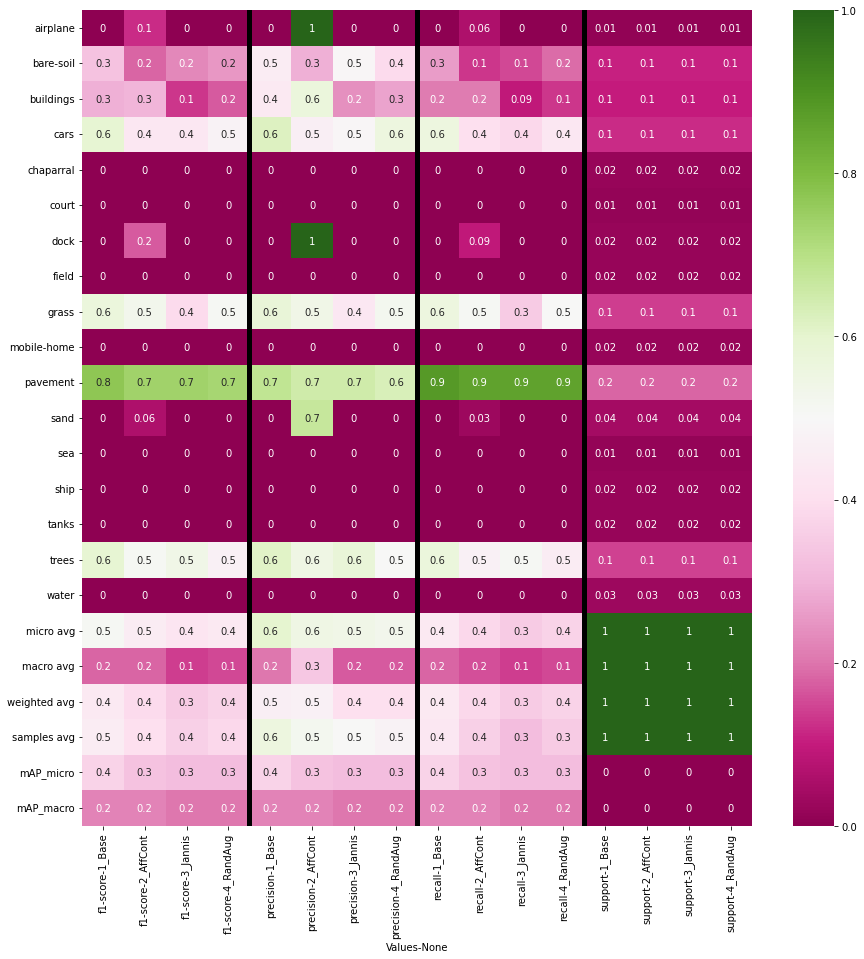

In [213]:
fig, ax = plt.subplots(1,figsize=(15,15))
sns.heatmap(new_df,ax=ax,cmap="PiYG",annot=True,fmt=".0g")
ax.plot((4,4),(0,26),color="black",linewidth=5)
ax.plot((8,8),(0,26),color="black",linewidth=5)
ax.plot((12,12),(0,26),color="black",linewidth=5)

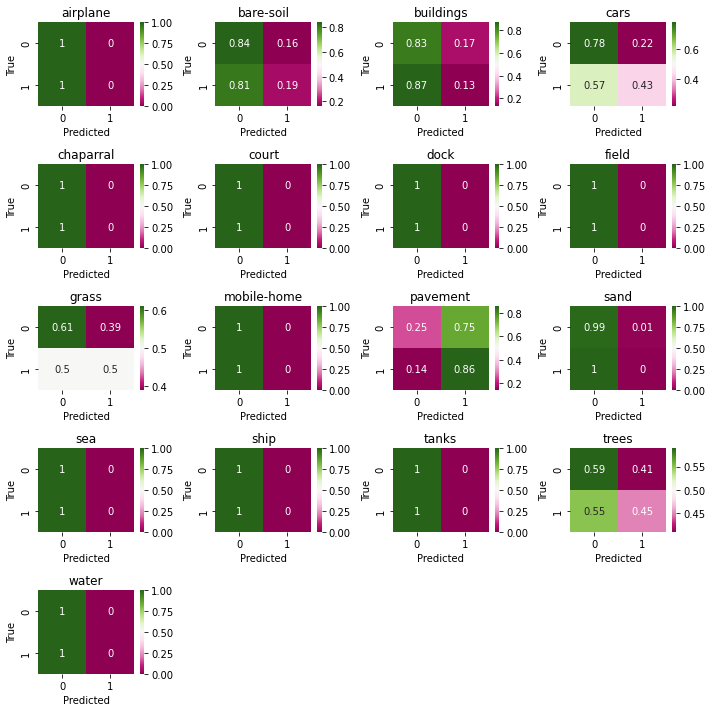

In [218]:
fig = prettify_confusion_matrix(conf_mat,mylabels,True)

## Display example images for the different augmentation strategies

In [ ]:
def label_individual_image(model,img):
    model.eval()
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
        probs = torch.sigmoid(logits)
        probs = np.where(np.array(probs)>=0.5, 1., 0.)[0]
    return probs   

def get_labels(labels,mylabels=mylabels)->list:
    return_labels = []
    labels = labels.tolist()
    for l in range(len(labels)):
        if labels[l] == 1.:
            return_labels.append(mylabels[l])
    return return_labels

def display_specific_image(model,loader,batch_nr,image_nr,method="Undefined",ax=None):
    number_of_batches = len(loader)
    current_batch = 0
    for b in loader:
        if current_batch != batch_nr:
            current_batch +=1 
            continue
        img = b["img"][image_nr]
        lab = b["label"][image_nr]
        probs = label_individual_image(model,img)
        aps = average_precision_score(lab,probs)
        img = img.numpy().transpose((1, 2, 0))
        img = ucm_std * img + ucm_mean
        img = np.clip(img,0.0,1.0)
        
        true_labels = get_labels(lab)
        pred_labels = get_labels(probs)
        if ax == None: fig, ax = plt.subplots()
        ax.set_xlabel(f"True {true_labels}")
        ax.set_title(f"Predicted {pred_labels}")
        ax.set_ylabel(f"Method {method}")
        ax.text(64,5,f"Precision:\n{aps}")
        current_batch +=1

        ax.imshow(img,norm=None)
        if current_batch >= number_of_batches: 
            break
    return ax

In [ ]:
def get_good_images():
    current_batch = 0
    list_of_good_images = []
    for v in base_test_loader:
        for x in range(len(v["label"])):
            img = v["img"][x]
            lab = v["label"][x]
            probs = label_individual_image(base_best_model,img)
            aps =average_precision_score(lab,probs)
            if aps >= 0.8: 
                print(current_batch,x,aps,get_labels(lab),get_labels(probs))
                list_of_good_images.append((current_batch,x))
        current_batch += 1
    return list_of_good_images
#good_images = get_good_images() # Skip as i have already selected my favorits

1 16 0.8088235294117647 ['buildings', 'cars', 'pavement', 'trees'] ['buildings', 'cars', 'trees']
1 24 0.8088235294117647 ['buildings', 'grass', 'pavement', 'trees'] ['grass', 'pavement', 'trees']
1 26 0.8088235294117647 ['buildings', 'cars', 'pavement', 'trees'] ['buildings', 'pavement', 'trees']
2 2 0.8333333333333334 ['bare-soil', 'buildings', 'cars', 'pavement', 'trees'] ['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
2 13 0.8588235294117648 ['buildings', 'cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement', 'trees']
2 25 1.0 ['cars', 'pavement', 'trees'] ['cars', 'pavement', 'trees']
2 26 1.0 ['bare-soil', 'cars', 'pavement'] ['bare-soil', 'cars', 'pavement']
2 27 0.8088235294117647 ['cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement']
2 42 1.0 ['bare-soil', 'cars', 'pavement'] ['bare-soil', 'cars', 'pavement']
2 45 1.0 ['trees'] ['trees']
2 51 0.8088235294117647 ['cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement']
3 0 

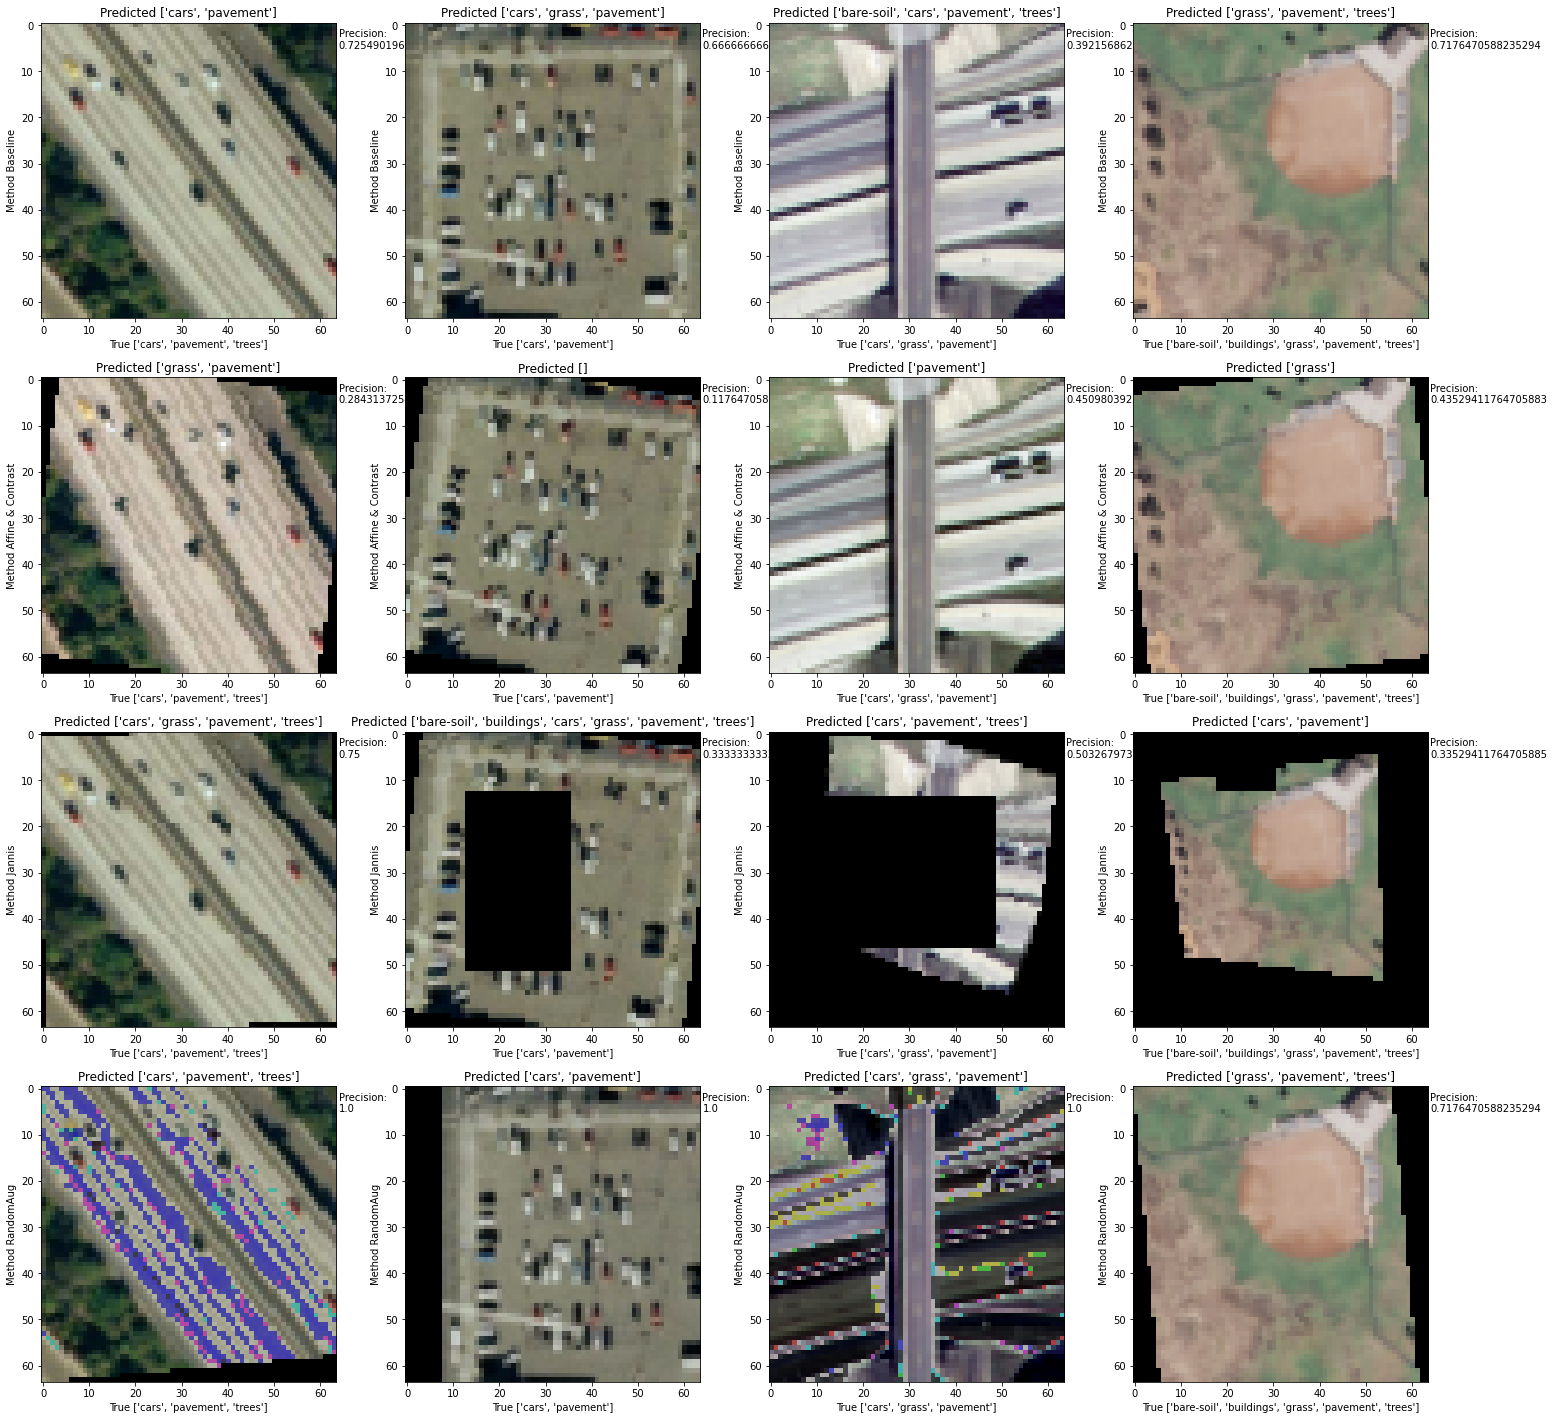

In [224]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,4,figsize=(25,25))

display_specific_image(base_best_model,base_test_loader,2,25,"Baseline",ax[0,0])
display_specific_image(base_best_model,base_test_loader,4,56,"Baseline",ax[0,1])
display_specific_image(base_best_model,base_test_loader,5,0,"Baseline",ax[0,2])
display_specific_image(base_best_model,base_test_loader,0,34,"Baseline",ax[0,3])

display_specific_image(affcont_model,affcont_test_loader,2,25,"Affine & Contrast",ax[1,0])
display_specific_image(affcont_model,affcont_test_loader,4,56,"Affine & Contrast",ax[1,1])
display_specific_image(affcont_model,affcont_test_loader,5,0,"Affine & Contrast",ax[1,2])
display_specific_image(affcont_model,affcont_test_loader,0,34,"Affine & Contrast",ax[1,3])

display_specific_image(jannis_model,jannis_test_loader,2,25,"Jannis",ax[2,0])
display_specific_image(jannis_model,jannis_test_loader,4,56,"Jannis",ax[2,1])
display_specific_image(jannis_model,jannis_test_loader,5,0,"Jannis",ax[2,2])
display_specific_image(jannis_model,jannis_test_loader,0,34,"Jannis",ax[2,3])

display_specific_image(rand_best_model,randaug_test_loader,2,25,"RandomAug",ax[3,0])
display_specific_image(rand_best_model,randaug_test_loader,4,56,"RandomAug",ax[3,1])
display_specific_image(rand_best_model,randaug_test_loader,5,0,"RandomAug",ax[3,2])
display_specific_image(rand_best_model,randaug_test_loader,0,34,"RandomAug",ax[3,3])
fig.savefig(transparent=True,fname="./images/augmentation_examples.eps",format="eps")